In [30]:
!datalad get ~/Desktop/studyforrest-data-eyemovementlabels
!datalad install ~/Desktop/studyforrest-data-eyemovementlabels

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [3]:
'''Housekeeping happens here.'''
sub_test_list = ['%.2d' % i for i in range(1, 20)]
sub_train_list= ['%.2d' % i for i in range(21, 37)]
run_list = ['%.1d' % j for j in range(1, 9)]

In [4]:
print('fMRI-Subjects: ', sub_test_list)
print('in-lab-Subjects: ', sub_train_list)

fMRI-Subjects:  ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
in-lab-Subjects:  ['21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36']


In [5]:
# delete missing subjects from combi dataset
sub_test_list.remove('07')
sub_test_list.remove('08')
sub_test_list.remove('11')
sub_test_list.remove('12')
sub_test_list.remove('13')

# delete missing subjects from in-lab dataset
sub_train_list.remove('21')

data_dir = os.path.expanduser('~') + '/Desktop/studyforrest-data-eyemovementlabels'
out_dir = data_dir + '/code/output'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

**Possible types and measures of similarity (or: wtf is the same)?**
- What types of eye-movement (e. g. fixation, saccades, ...) did they use?
- Where did subjects look (start_x, start_y & end_x, end_y)?
- How long were they looking (duration)?

In [6]:
def load_eye_data(data_dir, sub, run):
    '''
    Load individual eye-gaze paths for each subject.
    '''
    sub_data = data_dir + f'/sub-{sub}/sub-{sub}_task-movie_run-{run}_events.tsv' 
    eye_data = pd.read_csv(sub_data, sep='\t')
    eye_data.insert(loc=0, column='subject', value=int(sub))
    eye_data.insert(loc=1, column='run', value=int(run))
    
    return eye_data

In [7]:
def split_data(in_data, start_onset, stop_onset, time_step):
    '''
    Take input data, divide data into unequal chunks based on start and stop onsets, 
    return array of chunks.
    '''
    chunk_list = []
    for chunk in range(1, len(in_data['onset'])):
        
        if not in_data[(in_data['onset'] < stop_onset) & (in_data['onset'] > start_onset)].empty:
            chunk_tmp = in_data[(in_data['onset'] < stop_onset) & (in_data['onset'] > start_onset)]
            chunk_tmp.insert(loc=2, column='chunk', value=int(chunk))
            chunk_list.append(chunk_tmp)
            start_onset += time_step
            stop_onset += time_step
        
        else:
            break
            
    return chunk_list

In [ ]:
start_onset = 0
stop_onset = 12
time_step = 12

labeled_train_data_out = []

In [8]:
for sub in sub_train_list:
    for run in run_list: 
        '''
        Loop through all subjects and runs, combine the specified columns.
        '''
        tmp_data = load_eye_data(data_dir, sub, run)[['subject', 'run',  'onset', 'duration', 
                                                      'label', 'start_x', 'start_y', 'end_x', 'end_y']]
        labeled_train_data_out.append(tmp_data)

# combine the data
labeled_train_data = pd.concat(labeled_train_data_out, ignore_index=True)

# chunk the data 
chunk_train_data = pd.concat(split_data(in_data=labeled_train_data, start_onset=start_onset, 
                                        stop_onset=stop_onset, time_step=time_step), ignore_index=True)

**Get some descriptives for communication.**

In [9]:
chunk_train_data[(chunk_train_data['subject'] == 22)]

,subject,run,chunk,onset,duration,label,start_x,start_y,end_x,end_y
0,22,1,1,0.024,0.033,SACC,675.3,261.4,595.8,265.1
1,22,1,1,0.057,0.088,FIXA,596.2,265.2,593.5,264.8
2,22,1,1,0.145,0.114,PURS,593.3,264.9,590.1,265.6
3,22,1,1,0.259,0.191,FIXA,590.2,265.5,591.1,264.8
4,22,1,1,0.450,0.031,SACC,591.5,264.2,652.6,212.5
...,...,...,...,...,...,...,...,...,...,...
820573,22,7,91,1083.769,0.206,FIXA,804.1,165.2,828.6,154.1
820574,22,7,91,1083.975,0.036,SACC,829.0,153.6,1023.0,137.0
820575,22,7,91,1084.011,0.014,LPSO,1023.3,137.6,1012.1,132.2
820576,22,7,91,1084.025,0.045,PURS,1012.5,131.7,1021.1,133.5


In [10]:
eyegaze_features = pd.unique(chunk_train_data['label']) # categorical data: get different labels types
eyegaze_features

array(['SACC', 'FIXA', 'PURS', 'LPSO', 'HPSO', 'ISAC', 'ILPS', 'IHPS'],
      dtype=object)

In [11]:
for run in run_list:
    print(f'Number of chunks in run-{run}: ', 
          np.max(chunk_train_data[(chunk_train_data['run'] == int(run))]['chunk']))

Number of chunks in run-1:  76
Number of chunks in run-2:  74
Number of chunks in run-3:  74
Number of chunks in run-4:  82
Number of chunks in run-5:  78
Number of chunks in run-6:  74
Number of chunks in run-7:  91
Number of chunks in run-8:  57


In [15]:
from scipy.sparse import issparse

def gower_eye_matrix(data_x, data_y=None, weight=None, cat_features=None):
    '''
    Original implementation @ https://github.com/wwwjk366/gower/
    Custom adaptation of the 'Gower-Distance' adapted for eye movement patterns. Check 
    statistical data types and use the appropriate distance measure (numerical=Manhattan 
    Distance; categorical=Dice Distsance). Account for label order within each chunk. Calculate 
    a weighted sum of the outcome.
    '''
   # function checks
    X = data_x
    if data_y is None: Y = data_x 
    else: Y = data_y 
    if not isinstance(X, np.ndarray): 
        if not np.array_equal(X.columns, Y.columns): raise TypeError("X and Y must have same columns!")   
    else: 
         if not X.shape[1] == Y.shape[1]: raise TypeError("X and Y must have same y-dim!")  
                
    if issparse(X) or issparse(Y): raise TypeError("Sparse matrices are not supported!")        
            
    x_n_rows, x_n_cols = X.shape
    y_n_rows, y_n_cols = Y.shape 
    
    if cat_features is None:
        if not isinstance(X, np.ndarray): 
            is_number = np.vectorize(lambda x: not np.issubdtype(x, np.number))
            cat_features = is_number(X.dtypes)    
        else:
            cat_features = np.zeros(x_n_cols, dtype=bool)
            for col in range(x_n_cols):
                if not np.issubdtype(type(X[0, col]), np.number):
                    cat_features[col]=True
    else:          
        cat_features = np.array(cat_features)
    
    # print(cat_features)
    
    if not isinstance(X, np.ndarray): X = np.asarray(X)
    if not isinstance(Y, np.ndarray): Y = np.asarray(Y)
    
    Z = np.concatenate((X,Y))
    
    x_index = range(0,x_n_rows)
    y_index = range(x_n_rows,x_n_rows+y_n_rows)
    
    Z_num = Z[:,np.logical_not(cat_features)]
    
    num_cols = Z_num.shape[1]
    num_ranges = np.zeros(num_cols)
    num_max = np.zeros(num_cols)
    
    for col in range(num_cols):
        col_array = Z_num[:, col].astype(np.float32) 
        max = np.nanmax(col_array)
        min = np.nanmin(col_array)
     
        if np.isnan(max):
            max = 0.0
        if np.isnan(min):
            min = 0.0
        num_max[col] = max
        num_ranges[col] = (1 - min / max) if (max != 0) else 0.0

    # This is to normalize the numeric values between 0 and 1.
    Z_num = np.divide(Z_num ,num_max,out=np.zeros_like(Z_num), where=num_max!=0)
    Z_cat = Z[:,cat_features]
    
    if weight is None:
        weight = np.ones(Z.shape[1])
        
    #print(weight)    
    
    weight_cat=weight[cat_features]
    weight_num=weight[np.logical_not(cat_features)]   
        
    out = np.zeros((x_n_rows, y_n_rows), dtype=np.float32)
        
    weight_sum = weight.sum()
    
    X_cat = Z_cat[x_index,]
    X_num = Z_num[x_index,]
    Y_cat = Z_cat[y_index,]
    Y_num = Z_num[y_index,]
    
   # print(X_cat,X_num,Y_cat,Y_num)
    
    for i in range(x_n_rows):          
        j_start= i        
        if x_n_rows != y_n_rows:
            j_start = 0
        # call the main function
        res = gower_get(X_cat[i,:], 
                          X_num[i,:],
                          Y_cat[j_start:y_n_rows,:],
                          Y_num[j_start:y_n_rows,:],
                          weight_cat,
                          weight_num,
                          weight_sum,
                          cat_features,
                          num_ranges,
                          num_max) 
        #print(res)
        out[i,j_start:]=res
        if x_n_rows == y_n_rows: out[i:,j_start]=res
        
    return out

In [16]:
def gower_get(xi_cat,xi_num,xj_cat,xj_num,feature_weight_cat,
              feature_weight_num,feature_weight_sum,categorical_features,
              ranges_of_numeric,max_of_numeric ):
    
    # categorical columns
    sij_cat = np.where(xi_cat == xj_cat,np.zeros_like(xi_cat),np.ones_like(xi_cat))
    sum_cat = np.multiply(feature_weight_cat,sij_cat).sum(axis=1) 

    # numerical columns
    abs_delta=np.absolute(xi_num-xj_num)
    sij_num=np.divide(abs_delta, ranges_of_numeric, out=np.zeros_like(abs_delta), where=ranges_of_numeric!=0)

    sum_num = np.multiply(feature_weight_num,sij_num).sum(axis=1)
    sums= np.add(sum_cat,sum_num)
    sum_sij = np.divide(sums,feature_weight_sum)
    
    return sum_sij

In [41]:
gower_eye_matrix(chunk_train_data[(chunk_train_data['subject'] == int(22)) &
                                              (chunk_train_data['run'] == 1) & 
                                              (chunk_train_data['chunk'] == 1)])

array([[0.        , 0.1148558 , 0.11992764, ..., 0.13130492, 0.3178934 ,
        0.14176399],
       [0.1148558 , 0.        , 0.10533369, ..., 0.24374165, 0.21238089,
        0.25368506],
       [0.11992764, 0.10533369, 0.        , ..., 0.24747956, 0.30824003,
        0.25742295],
       ...,
       [0.13130492, 0.24374165, 0.24747956, ..., 0.        , 0.19701374,
        0.01592126],
       [0.3178934 , 0.21238089, 0.30824003, ..., 0.19701374, 0.        ,
        0.20403144],
       [0.14176399, 0.25368506, 0.25742295, ..., 0.01592126, 0.20403144,
        0.        ]], dtype=float32)

In [46]:
gower_eye_matrix(chunk_train_data[(chunk_train_data['subject'] == int(22)) &
                                              (chunk_train_data['run'] == 1) & 
                                              (chunk_train_data['chunk'] == 1)]).shape

(103, 103)

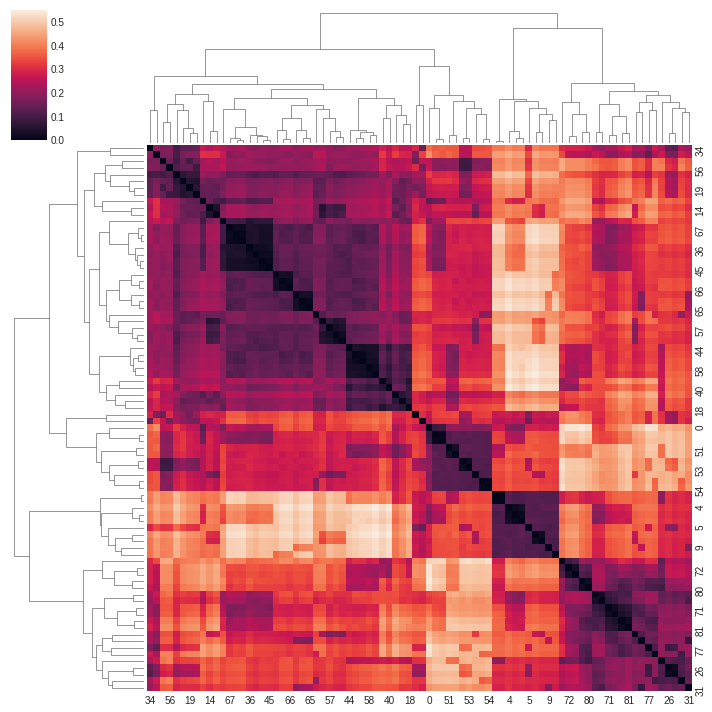

In [39]:
sns.clustermap(gower_eye_matrix(chunk_train_data[(chunk_train_data['subject'] == int(22)) &
                                  (chunk_train_data['run'] == 1) & 
                                 (chunk_train_data['chunk'] == 20)]))